<div class="alert alert-block alert-info">

# IMPLEMENTATION D'UN MODELE DE SCORING

> La société financière "Prêt à dépenser" propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. Elle souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifier la demande en crédit accordé ou refusé :
    <ul>
        <li>elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.),</li>
        <li>elle souhaite aussi développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.</li>
    </ul>

> L'objectif est donc de :
    <ul>
        <li>construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,</li>
        <li>construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client de ces gestionnaires ; ce dashboard remplira les fonctionnalités suivantes :</li>
            <ul>
                <li> visualisation du score et interprétation de ce score pour chaque client,</li>
                <li> visualisation des informations descriptives relatives à un client (via un système de filtre),</li>
                <li> comparaison des informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.</li>
            </ul>
    </ul>

> L'étude se décompose en différentes étapes :
    <ul>
        <li>une analyse exploratoire des données pour définir les données pertinentes,</li>
        <li>l'apprentissage de plusieurs méthodes de classification afin de sélectionner le plus optimal,</li>
            <ul>
                <li>méthode dummy,</li>
                <li>régression logistique,</li>
                <li>arbre de décision,</li>
                <li>random forest,</li>
                <li>méthode extra tree,</li>
                <li>méthode XGB,</li>
                <li>méthode AdaBoost,</li>
                <li>méthode des k plus proches voisins,</li>
            </ul>
        <li><b>une synthèse sur la pertinence des variables pour le modèle de classification choisi.</b></li>
    </ul>

Les données sont fournies à l'adresse : 
https://www.kaggle.com/c/home-credit-default-risk/data - Projet+Mise+en+prod+-+home-credit-default-risk.zip

</div>

<div class="alert alert-block alert-info">

## 1. ANALYSE DES RESULTATS DES CLASSIFICATIONS ETUDIEES

</div>

<div class="alert alert-block alert-info">
    
### 1.1 Importation des bibliothèques
    
</div>

In [1]:
# Importation des librairies
import os
import gc
import time
import datetime
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import numpy.random as nr

import scipy.stats as st
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
palette = sns.color_palette('Paired')
tab10 = sns.color_palette('tab10')
sns.set_context('paper', rc = {'font.size':12, 'figure.titlesize':18, 
                               'axes.titlesize':15, 'axes.labelsize':13, 
                               'xtick.labelsize': 13, 'ytick.labelsize': 13, 
                               'legend.fontsize': 9, 'legend.title_fontsize': 11}) 
import ipywidgets
import pickle

# Faire apparaître les graphiques dans le notebook
%matplotlib inline

<div class="alert alert-block alert-info">
    
### 1.2 Résultats des classifications
    
</div>

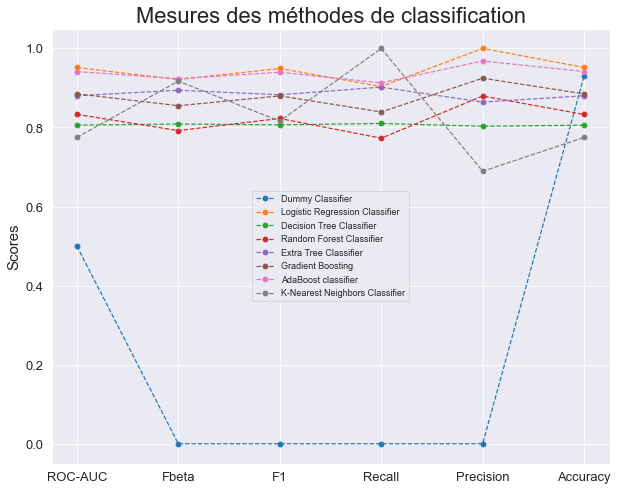

In [2]:
# Résultats des métriques des classifications
res = pd.read_csv('donnees/resultats/results_classification.csv', sep = ',', index_col = 0)

fig = plt.figure(figsize = (10,8))
metrics = ['DC_Test', 'LR_Test', 'DT_Test', 'RF_Test', 'ET_Test', 'GB_Test', 'AD_Test', 'KNN_Test']
metrics_labels = ['Dummy Classifier', 'Logistic Regression Classifier', 'Decision Tree Classifier', 
                  'Random Forest Classifier', 'Extra Tree Classifier', 'Gradient Boosting', 
                  'AdaBoost classifier', 'K-Nearest Neighbors Classifier']

for i, clas in enumerate(res[metrics]):
    plt.plot(res[clas], marker='o', linestyle='dashed', color=tab10[i], label=metrics_labels[i])
    plt.ylabel('Scores', fontsize=15)
plt.legend(loc='best')
plt.title('Mesures des méthodes de classification', fontsize=22)
plt.show()

<div class="alert alert-block alert-info">
    
Le graphe ci-dessus compare les résultats de différentes mesures, obtenues sur des données de test, après apprentissage 
de plusieurs méthodes de classification. La régression logistique semble donner les meilleurs résutats sur l'ensemble des métriques (valeurs supérieures à 0.9), dont le score AUC qui est la mesure privilégiée lors de la recherche des meilleurs modèles.<br>
La précision de valeur "1" fait cependant redouter un sur-apprentissage sur les données fournies. Nous allons donc privilégier la classification Extra Tree qui fournit des valeurs similaires pour toutes les métriques avec un des meilleurs scores pour le rappel (minimisation des faux positifs).<br><br>
La suite du notebook présente :
<ul> 
    <li>un rejeu de la méthode "Gradient Boosting" optimisée</li>
    <li>une analyse des performances du modèle</li>
</ul>

</div>

<div class="alert alert-block alert-info">

## 2. RETRAITEMENT DU DATASET PAR LA METHODE DE CLASSIFICATION 

</div>

<div class="alert alert-block alert-info">

### 2.1 Chargement du dataset et standardisation des données

</div>

In [3]:
# Jeux des données d'entraînement du fichier application 
data = pd.read_csv('donnees/transformees/data_train.csv', sep = ',')
print("Nettoyage des données du fichier application : ")
print("   - Nombre d'individus : ", data.shape[0])
print("   - Nombre de variables : ", data.shape[1])
data.head()

Nettoyage des données du fichier application : 
   - Nombre d'individus :  307488
   - Nombre de variables :  442


TARGET  DAYS_BIRTH  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0     1.0    0.881337         0.705433               1                0   
1     0.0    0.473087         0.959566               1                0   
2     0.0    0.345593         0.648326               1                1   
3     0.0    0.347884         0.661387               1                0   
4     0.0    0.296071         0.519522               1                0   

   FLAG_PHONE  FLAG_EMAIL  REG_REGION_NOT_LIVE_REGION  \
0           1           0                           0   
1           1           0                           0   
2           1           0                           0   
3           0           0                           0   
4           0           0                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  ...  \
0                           0                            0  ...   
1                           0                            0  ...   
2                           0                            0  ...   
3                           0                            0  ...   
4                           0                            0  ...   

   FONDKAPREMONT_MODE_org spec account  FONDKAPREMONT_MODE_reg oper account  \
0                                    0                                    1   
1                                    0                                    1   
2                                    0                                    1   
3                                    0                                    1   
4                                    0                                    1   

   FONDKAPREMONT_MODE_reg oper spec account  WALLSMATERIAL_MODE_Block  \
0                                         0                         0   
1                                         0                         1   
2                                         0                         0   
3                                         0                         0   
4                                         0                         0   

   WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
0                         0                              0   
1                         0                              0   
2                         0                              0   
3                         0                              0   
4                         0                              0   

   WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
0                          0                         0   
1                          0                         0   
2                          0                         1   
3                          0                         1   
4                          1                         0   

   WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  
0                                1                          0  
1                                0                          0  
2                                0                          0  
3                                0                          0  
4                                0                          0  

[5 rows x 442 columns]

In [4]:
# On sépare la variable cible que l'on souhaite prédire des varaibles prédictives.
y_target = 'TARGET'
X_columns = data.columns.drop(y_target)

<div class="alert alert-block alert-info">

### 2.2 Apprentissage du modèle sur les données échantillonnées

</div>

In [5]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Sélection des variables
def select_features(X1, y1, X2):
    # Sélection d'un sous-ensemble de variables
    fs = SelectFromModel(RandomForestClassifier(n_estimators=50, max_features='sqrt'))
    # Apprentissage des relations des données d'entraînement (X1, y1)
    fs.fit(X1, y1)
    # Transformation des données d'entraînement d'entrée
    X1_fs = fs.transform(X1)
    # Transformation des données de test d'entrée
    X2_fs = fs.transform(X2)
    # Noms des features sélectionnées 
    f_names = fs.get_feature_names_out(input_features=None)
    
    return X1_fs, X2_fs, f_names, fs

# Tracé des effectifs de la variable cible (apprentissage et test)
def target_feature_plot(X, Y):
    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(10, 5)
    
    plt.suptitle('Effectifs de la variable cible par classe', fontsize=22)
    
    plt.subplot(121)
    X.sort_values().value_counts().plot(kind='bar', color=[palette[0], palette[1]], title='Données d\'apprentissage')
    classes = pd.Series(X.sort_values().value_counts())
    for i in list(classes.index):
        plt.text(i-0.15, classes[i], str(classes[i]), color='black', verticalalignment='center', fontsize=15)
    
    plt.subplot(122)
    Y.sort_values().value_counts().plot(kind='bar', color=[palette[2], palette[3]], title='Données de test')
    classes = pd.Series(Y.sort_values().value_counts())
    for i in list(classes.index):
        plt.text(i-0.15, classes[i], str(classes[i]), color='black', verticalalignment='center', fontsize=15)
    
    plt.tight_layout()

# Tracé des effectifs de la variable cible (par ré-équilibrage)
def classes_balancing_plot(X, Y, title):
    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(10, 5)
    
    plt.suptitle(title, fontsize=22)
    
    plt.subplot(121)
    X.sort_values().value_counts().plot(kind='bar', color=[palette[6], palette[7]], title='Données brutes')
    classes = pd.Series(X.sort_values().value_counts())
    for i in list(classes.index):
        plt.text(i-0.15, classes[i], str(classes[i]), color='black', verticalalignment='center', fontsize=15)
    
    plt.subplot(122)
    Y.sort_values().value_counts().plot(kind='bar', color=[palette[8], palette[9]], title='Données ré-échantilonnées')
    classes = pd.Series(Y.sort_values().value_counts())
    for i in list(classes.index):
        plt.text(i-0.15, classes[i], str(classes[i]), color='black', verticalalignment='center', fontsize=15)
    
    plt.tight_layout()

# Evaluation des performances du modèle
def model_performance(y_true, y_pred, label):
    return pd.Series({'ROC-AUC' : roc_auc_score(y_true, y_pred),
                      'Fbeta': fbeta_score(y_true, y_pred, beta= 2),
                      'F1': f1_score(y_true, y_pred),
                      'Recall': recall_score(y_true, y_pred),
                      'Precision': precision_score(y_true, y_pred),
                      'Accuracy': accuracy_score(y_true, y_pred, normalize=True)
                     }, name=label)

# Tracé des métriques de la classification
def metrics_classification_plot(X):
    fig = plt.figure(figsize=(6,6))
    
    pos = list(range(len(X[X.columns[0]])))
    width = 0.4
    
    plt.title("Résultats des métriques de la classification", fontsize=22)
    plt.barh([p + 0.1 for p in pos], X[X.columns[0]], width, color=palette[0], label='Train')
    for i, v in enumerate(X[X.columns[0]]):
        plt.text(v, i + .25, str(round(v, 2)), color=palette[1], fontweight = 'bold', verticalalignment='top')
    plt.barh([p + 0.1 + width for p in pos], X[X.columns[1]], width, color=palette[2], label='Test')
    for i, v in enumerate(X[X.columns[1]]):
        plt.text(v, i + .25, str(round(v, 2)), color=palette[3], fontweight = 'bold', verticalalignment='bottom')
    plt.yticks([p + 0.3 for p in pos], X.index)
    plt.xlim(.0, 1.0)
    plt.legend(loc='best')
    
    plt.show()

# Matrice de confusion
def confusion_matrix_plot(y_true, y_pred):
    sns.set_context('talk')
    cm = confusion_matrix(y_true, y_pred)
    _, ax = plt.subplots(figsize=(8,6))

    group_names = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap=palette, annot_kws={"size": 14, "weight": "bold"})
    
    plt.suptitle('Matrice de confusion', fontsize=22)
    ax.set_xlabel('Valeurs prédictives', fontsize=16)
    ax.set_ylabel('Valeurs réelles', fontsize=16)
    ax.set_xticklabels(['Faux','Vrai'], fontsize=14)
    ax.set_yticklabels(['Faux','Vrai'], fontsize=14)
    
    plt.show()

# Tracé des courbes ROC-AUC et Précision/Rappel
def measure_performance_plot(y_test, y_prob):
    sns.set_context('talk')
    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(12, 7)
    
    plt.suptitle('Courbes ROC-AUC and Precision-Recall', fontsize=22)

    # Plot the ROC-AUC curve
    ax = axList[0]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    ax.plot(fpr, tpr, linewidth=5)
    # It is customary to draw a diagonal dotted line in ROC plots.
    # This is to indicate completely random prediction. Deviation from this dotted line towards 
    # the upper left corner signifies the power of the model.
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='ROC curve')
    ax.grid(True)
    
    # Plot the precision-recall curve
    ax = axList[1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
    ax.plot(recall, precision, linewidth=5)
    ax.set(xlabel='Recall', 
           ylabel='Precision',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='Precision-Recall curve')
    ax.grid(True)
    
    plt.tight_layout()

def loss_plot(X):
    fig = plt.figure(figsize=(8,6))
    
    ax = X.plot(marker='.', linewidth=2)
    # Set parameters
    ax.set(xlabel='Nombre d\'arbres', ylabel='Erreur')
    ax.set_xlim(0, max(X.index)*1.1)
    
    plt.show()

<div class="alert alert-block alert-info">

#### 2.2.1 Modèlisation avec les hyperparamètres optimaux

</div>

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Apprentissage du modèle 
def model_training(mdl, X, y):
    # Préparation des données d'apprentissage et de test
    #    - créer les data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)
    #    - afficher la répartition de la variable cible 
    target_feature_plot(y_train, y_test)
    
    # Apprentissage du modèle
    mdl = mdl.fit(X_train, y_train)
    
    # Prédictions sur les data sets d'entraînement et de test
    y_train_predicted = mdl.predict(X_train)
    y_test_predicted = mdl.predict(X_test)
    y_test_probability = mdl.predict_proba(X_test)
    
    # Calcul des métriques
    m_clas = pd.concat([model_performance(y_train, y_train_predicted, 'MDL_Train'),
                        model_performance(y_test, y_test_predicted, 'MDL_Test')
                       ], axis=1)
    
    # Affichage des différentes métriques
    metrics_classification_plot(m_clas)
    confusion_matrix_plot(y_test, y_test_predicted)
    measure_performance_plot(y_test, y_test_probability)
    
    return mdl, X_train, y_train, X_test, y_test,\
           y_train_predicted, y_test_predicted, y_test_probability,\
           X_columns, m_clas

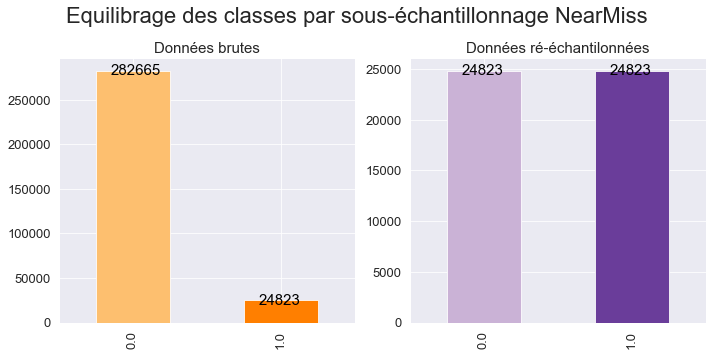

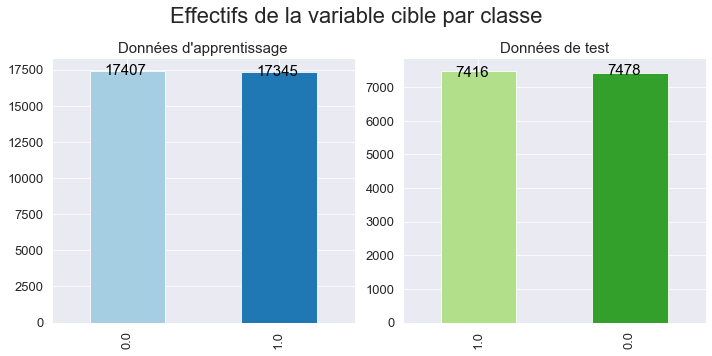

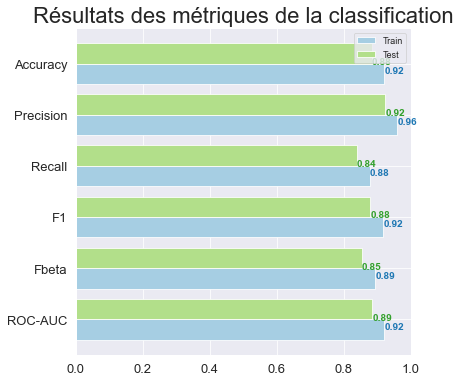

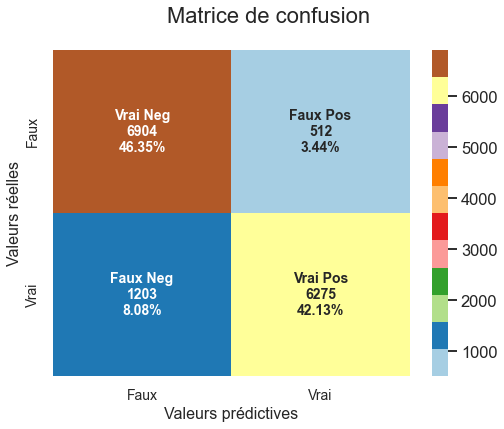

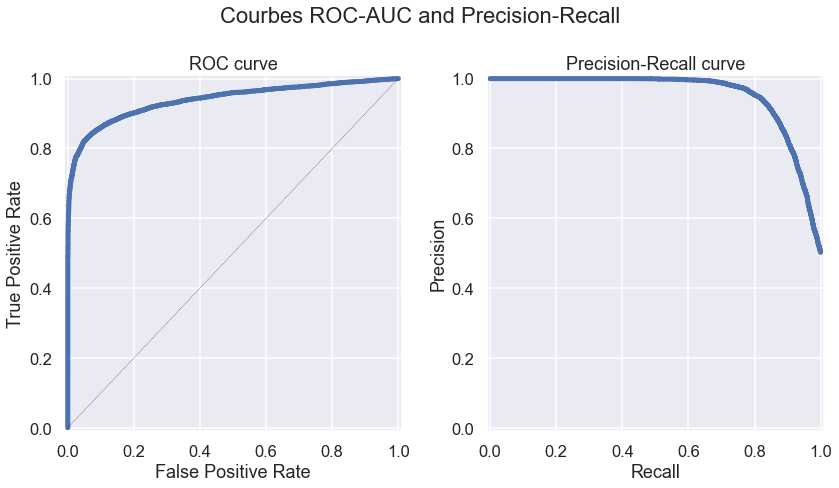

<Figure size 576x432 with 0 Axes>

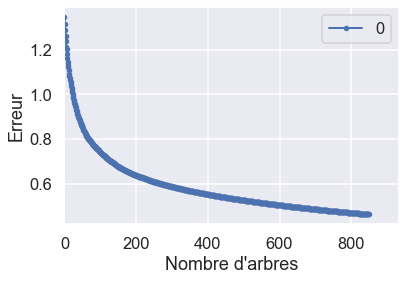


Temps d'exécution de l'apprentissage : 0:02:56.951398


29228

In [7]:
from imblearn.under_sampling import NearMiss

start = time.time()

# Initialisation du modèle
gb = GradientBoostingClassifier(criterion='friedman_mse', n_estimators=850, learning_rate=0.1, subsample=1.0, 
                                max_features='log2', random_state = 42)

# Séparation des variables predictives et de la variable cible
X = data[X_columns]
y = data[y_target]

# Rééquilibrage des classes
nm = NearMiss(sampling_strategy='majority', n_neighbors=3)
X_nm, y_nm = nm.fit_resample(X, y)

# Tracé du rééquilibrage des classes après sur-échantillonnage
titre = 'Equilibrage des classes par sous-échantillonnage NearMiss'
classes_balancing_plot(y, y_nm, titre)

# Apprentissage du modèle
gb, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_test_prob, f_names, clas_scores = \
                      model_training(gb, X_nm, y_nm)

# Affichage de l'erreur en fonction du nombre d'arbres
loss_plot(pd.DataFrame(gb.train_score_))

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

#del gb
#del X_train, y_train, X_test, y_test
#del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

## 3. ANALYSE DES PERFORMANCES DU MODELE 

</div>

<div class="alert alert-block alert-info">

### 3.1 Importances globales des variables dans la prédiction  

</div>

In [8]:
# Tracé des features selon leur importance dans l'apprentissage (classification binaire)
def feature_importances_plot(feature_names, features, feature_count):
    sns.set_context('talk')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
       
    f_imp_df = pd.DataFrame(features, feature_names, columns = ['Importance'])
    
    plt.suptitle('Feature importances', fontsize=22)
    # Plot the negative scores.
    f_imp_df_c0 = f_imp_df.sort_values(by=['Importance'], ascending=True)[:feature_count]
    if f_imp_df_c0['Importance'].min() < 0.:
        ax1.barh(f_imp_df_c0.index, f_imp_df_c0['Importance'], color=palette[5])
        ax1.yaxis.tick_left()
        ax1.set_yticklabels(f_imp_df_c0.index, fontsize=10)
    ax1.set_title('Negative importance')
    # Plot the positive scores.
    f_imp_df_c1 = f_imp_df.sort_values(by=['Importance'], ascending=False)[:feature_count]
    if f_imp_df_c1['Importance'].max() > 0.:
        ax2.barh(f_imp_df_c1.index, f_imp_df_c1['Importance'], color=palette[3])
        ax2.yaxis.tick_right()
        ax2.set_yticklabels(f_imp_df_c1.index, fontsize=10)
    ax2.set_title('Positive importance')

    plt.tight_layout()

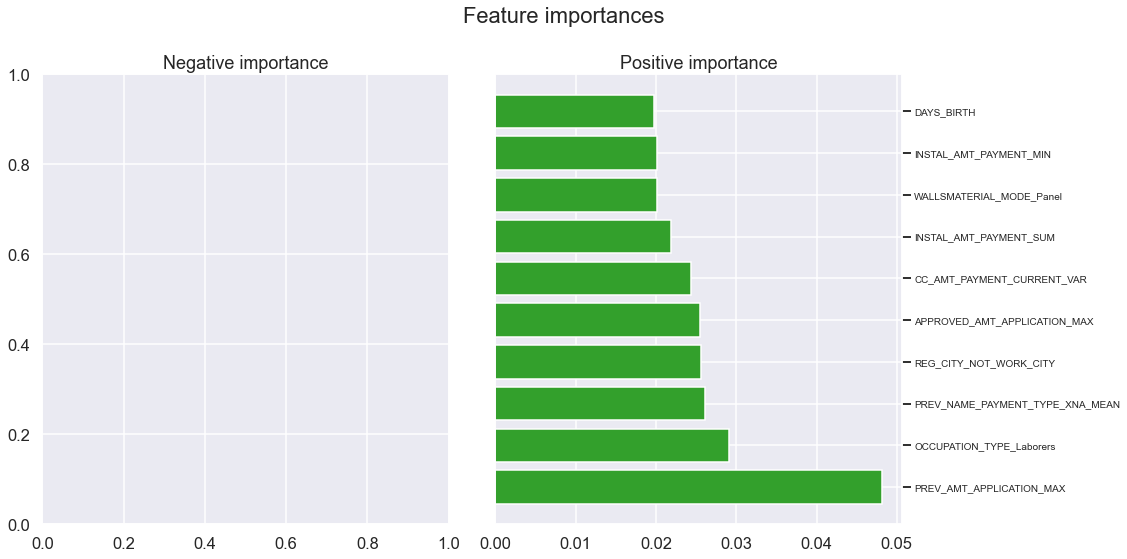

In [9]:
f_count = 10
feature_importances_plot(f_names, gb.feature_importances_, f_count)

<div class="alert alert-block alert-info">
    
Les variables qui contribuent le plus au modèle prédictif ont une participation positive (ci-dessus les 10 plus importantes). Leur contribution a une valeur comprise entre 0.02 et 0.05, ce qui semble relatif. Il ne semble pas se dégager de variables réellement prédominantes.<br>
Parmi ces variables, on trouve :
    <ul>
        <li>la catégorie socio-professionnelle des employés,</li>
        <li>le montant maximum demandé pour les crédits précédents,</li> 
        <li>le montant accordé pour le crédit en cours,</li>
        <li>le lieu de résidence / au lieu de travail</li>
        <li>l'âge des clients,</li>
        <li>le paiement des mensualités minimum et cumulés du crédit précédent.</li>
    </ul>

</div>

<div class="alert alert-block alert-info">

### 3.2 Analyse des performances

</div>

<div class="alert alert-block alert-info">
    
Le résultat ci-dessus est décomposé en importances positives, négatives et valeurs absolues. 

</div>

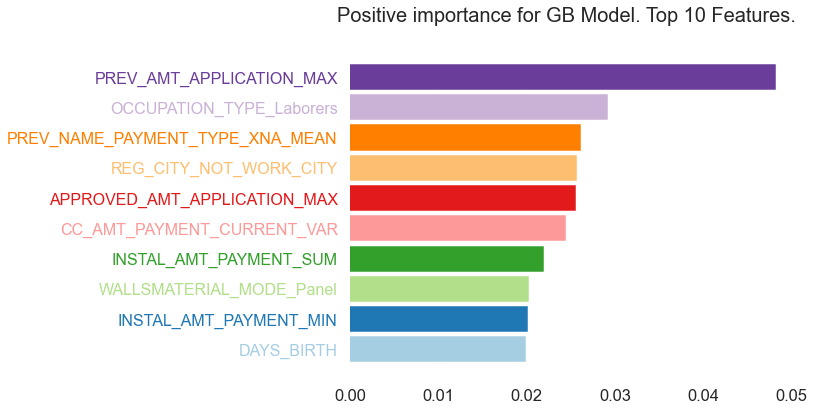

In [10]:
# Contribution les plus positives
fig = plt.figure(figsize=(8,6))
top_x = 10

indices = np.argsort(gb.feature_importances_)           # Tri croissant
indices = indices[-top_x:]

bars = plt.barh(range(len(indices)), gb.feature_importances_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [f_names[j] for j in indices], fontweight="normal", fontsize=16) 
for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(palette[i]) 
for i,bar in enumerate(bars):
    bar.set_color(palette[i])
plt.box(False)
plt.suptitle("Positive importance for GB Model. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal");

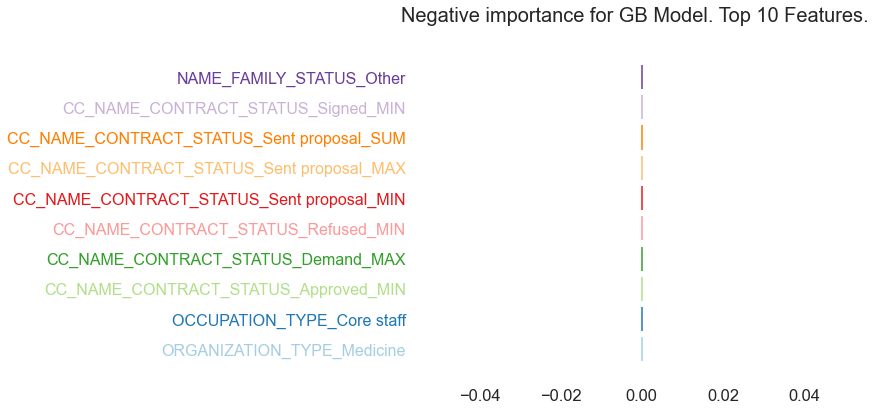

In [11]:
# Contribution les plus négatives
fig = plt.figure(figsize=(8,6))
top_x = 10

indices = np.argsort(gb.feature_importances_)           # Tri croissant
indices = indices[:top_x]

bars = plt.barh(range(len(indices)), gb.feature_importances_[indices], color='b', align='center') 
plt.yticks(range(len(indices)), [f_names[j] for j in indices], fontweight="normal", fontsize=16) 
for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
        ticklabel.set_color(palette[i]) 
for i,bar in enumerate(bars):
        bar.set_color(palette[i])
plt.box(False)
plt.suptitle("Negative importance for GB Model. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal");

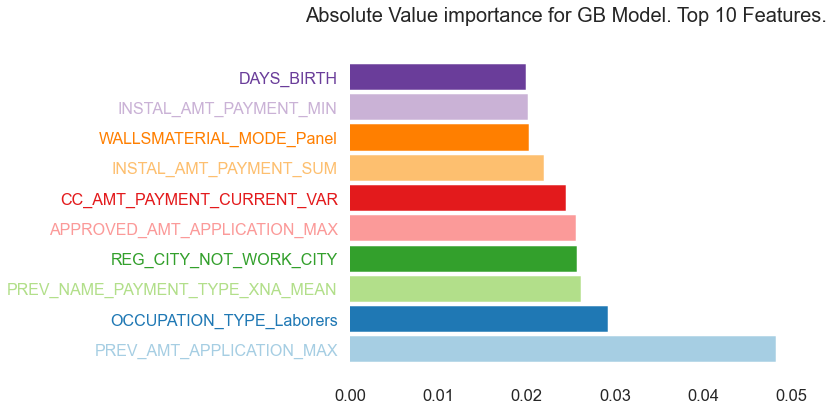

In [12]:
# Synthèse des variables les plus importantes
fig = plt.figure(figsize=(8,6))
top_x = 10

indices = np.argsort(np.abs(gb.feature_importances_))[::-1]     # Tri décroissant 
indices = indices[:top_x]

bars = plt.barh(range(len(indices)), np.abs(gb.feature_importances_)[indices], color='b', align='center')
plt.yticks(range(len(indices)), [f_names[j] for j in indices], fontweight="normal", fontsize=16) 
for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(palette[i]) 
for i,bar in enumerate(bars):
    bar.set_color(palette[i])
plt.box(False)
plt.suptitle("Absolute Value importance for GB Model. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal");

<div class="alert alert-block alert-info">

### 3.3 Analyse avec Lime

</div>

<div class="alert alert-block alert-info">
    
L'importance des variables est maintenant analysée pour un client. Il nous intéresse de connaître la hauteur de la contribution des variables qui ont influé sur le résultat de la classification d'un client. On analyse deux cas :
    <ul>
        <li>la prédiction correspond à la valeur réelle,</li>
        <li>la prédiction est contraire à la valeur réelle.</li>
    </ul>

</div>

In [13]:
from lime import lime_tabular

explainer1 = lime_tabular.LimeTabularExplainer(np.array(X_train), mode="classification", class_names=y_target,
                                              feature_names=f_names)

Prediction :  0.0
Actual :      0.0
Explanation Local Prediction  :  [0.66207508]
Explanation Global Prediction Probability :  [0.93951562 0.06048438]
Explanation Global Prediction :  0


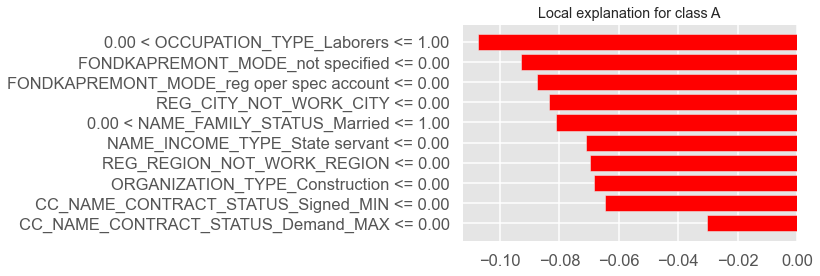

In [14]:
# Affichage de l'implication des variables sur la prédiction sur un exemple ou valeur prédictive <> valeur réelle 
true_preds = np.argwhere((np.array(y_test_pred) == np.array(y_test))).flatten()
idx  = np.random.choice(true_preds)

print("Prediction : ", y_test_pred[idx])
print("Actual :     ", y_test.iloc[idx])
explanation = explainer1.explain_instance(X_test.iloc[idx], gb.predict_proba)
#explanation.show_in_notebook()
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()

print("Explanation Local Prediction  : ", explanation.local_pred)
print("Explanation Global Prediction Probability : ", explanation.predict_proba)
print("Explanation Global Prediction : ", np.argmax(explanation.predict_proba))

<div class="alert alert-block alert-info">
    
Ci-dessus, la classe du client a été correctement prédite, malgré le fait qu'il ne soit pas un employé, n'habitant pas proche de son lieu de travail, et qu'il ne soit pas marié.<br>
Les premières caractéristiques qui ont contribué négativement à la prédiction. Parmi les 10 plus importantes, aucune n'a contribué positivement.  

</div>

Prediction :  0.0
Actual :      1.0
Explanation Local Prediction  :  [0.78366537]
Explanation Global Prediction Probability :  [0.77213218 0.22786782]
Explanation Global Prediction :  0


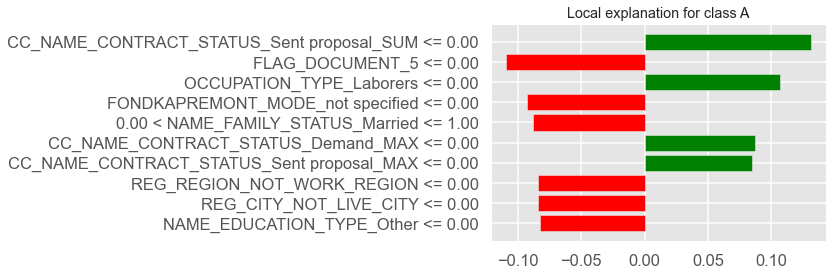

In [15]:
# Affichage de l'implication des variables sur la prédiction sur un exemple ou valeur prédictive <> valeur réelle 
false_preds = np.argwhere((np.array(y_test_pred) != np.array(y_test))).flatten()
idx  = np.random.choice(false_preds)

print("Prediction : ", y_test_pred[idx])
print("Actual :     ", y_test.iloc[idx])
explanation = explainer1.explain_instance(X_test.iloc[idx], gb.predict_proba)
#explanation.show_in_notebook(show=False)
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()

print("Explanation Local Prediction  : ", explanation.local_pred)
print("Explanation Global Prediction Probability : ", explanation.predict_proba)
print("Explanation Global Prediction : ", np.argmax(explanation.predict_proba))

<div class="alert alert-block alert-info">
    
Ci-dessus, la classe du client a été mal prédite. Nous observons cette fois-ci que les premières caractéristiques qui ont contribué positivement et négativement à la prédiction.<br>
Ici, le fait par exemple que le client soit un employé a contribué à l'acceptation du crédit. Pourtant, son crédit a été en réalité rejeté.

</div>

In [16]:
#explanation.save_to_file ('lime.html')

<div class="alert alert-block alert-info">

### 3.4 Analyse avec Shap

</div>

<div class="alert alert-block alert-info">
    
Nous avons souhaité ci-dessous tester quelques graphes que SHAP peut fournir.

</div>

In [18]:
import shap
shap.initjs()

explainer2 = shap.TreeExplainer(gb, masker=X_test)

In [19]:
# Affichage de l'implication des variables sur la prédiction sur un exemple ou valeur prédictive = valeur réelle 
true_preds = np.argwhere((np.array(y_test_pred) == np.array(y_test))).flatten()
idx  = np.random.choice(true_preds)

shap_vals = explainer2.shap_values(np.array(X_test.iloc[idx]).reshape(1, -1))
val0 = np.exp(explainer2.expected_value + shap_vals[0].sum())
#val1 = explainer2.expected_value[1] + shap_vals[1].sum()

print("Valeur de base : ", explainer2.expected_value)
#print()
#print("Valeur SHAP pour l'individu %d : "%idx, shap_vals)
#print("\n")
print("Prédiction du modèle                                         : ", \
      gb.predict_proba(np.array(X_test)[idx].reshape(1, -1))[0])
#print("Prédiction après ajout de la valeur SHAP à la valeur de base : ", [val0, val1], \
#      np.argmax([val0, val1]))
print("Prédiction après ajout de la valeur SHAP à la valeur de base : ", val0/(1+val0))

Valeur de base :  [0.6499627]
Prédiction du modèle                                         :  [0.00956101 0.99043899]
Prédiction après ajout de la valeur SHAP à la valeur de base :  [0.99043899]


In [20]:
# Affichage de l'implication des variables sur la prédiction sur un exemple ou valeur prédictive <> valeur réelle 
false_preds = np.argwhere((np.array(y_test_pred) != np.array(y_test))).flatten()
idx  = np.random.choice(false_preds)

shap_vals = explainer2.shap_values(np.array(X_test.iloc[idx]).reshape(1, -1))
val0 = np.exp(explainer2.expected_value + shap_vals[0].sum())
#val1 = explainer2.expected_value[1] + shap_vals[1].sum()

print("Valeur de base : ", explainer2.expected_value)
#print()
#print("Valeur SHAP pour l'individu %d : "%idx, shap_vals)
#print("\n")
print("Prédiction du modèle                                         : ", \
      gb.predict_proba(np.array(X_test)[idx].reshape(1, -1))[0])
#print("Prédiction après ajout de la valeur SHAP à la valeur de base : ", [val0, val1], \
#      np.argmax([val0, val1]))
print("Prédiction après ajout de la valeur SHAP à la valeur de base : ", val0/(1+val0))

Valeur de base :  [0.6499627]
Prédiction du modèle                                         :  [0.97414104 0.02585896]
Prédiction après ajout de la valeur SHAP à la valeur de base :  [0.02585896]


<div class="alert alert-block alert-info">
    
La valeur de la prédiction pour un client est calculée en ajoutant une valeur SHAP à une valeur de base afin de comparer la prédiction avec celle générée par régression linéaire.<br>
Ci-dessus, deux cas : *
    <ul>
        <li>la prédiction correspond à la valeur réelle,</li>
        <li>la prédiction est contraire à la valeur réelle.</li>
    </ul>

</div>

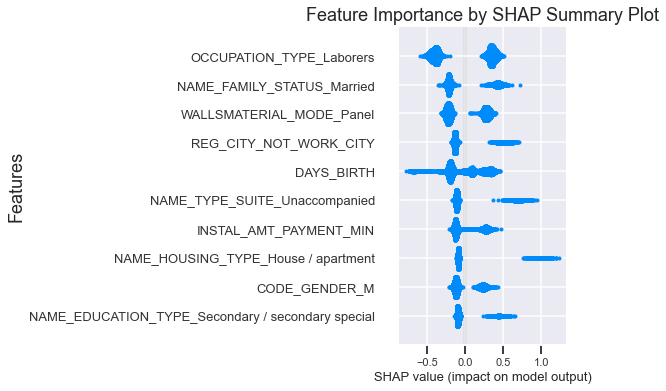

In [21]:
# Résumé de l'intrigue
#shap.summary_plot(explainer2.shap_values(np.array(X_test)), feature_names=f_names, max_display=10, plot_size=(12,12), show=False)
shap.summary_plot(explainer2.shap_values(X_test), feature_names=f_names, max_display=10, show=False)
plt.title("Feature Importance by SHAP Summary Plot")
plt.ylabel("Features")
plt.show()
#shap.summary_plot(explainer2.shap_values(np.array(X_test))[0], features=X_test, feature_names=f_names, max_display=20, plot_size=(12,12))
#shap.summary_plot(explainer2.shap_values(np.array(X_test))[1], features=X_test, feature_names=f_names, max_display=20, plot_size=(12,12))

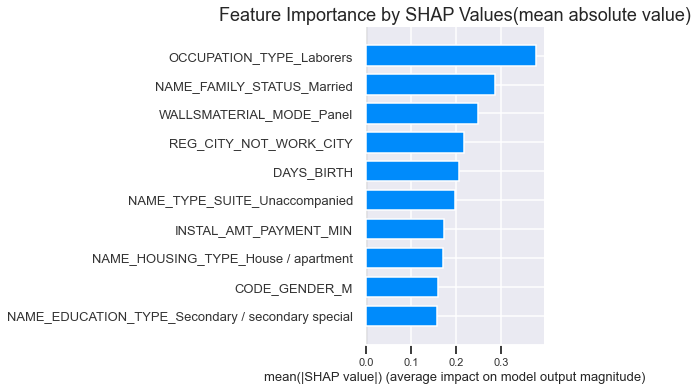

In [22]:
# Résumé de l'intrigue
shap.summary_plot(explainer2.shap_values(X_test), feature_names=f_names, plot_type="bar", max_display=10, show=False)
plt.title("Feature Importance by SHAP Values(mean absolute value)")
plt.show()

<div class="alert alert-block alert-info">
    
Les deux graphes ci-dessus représentent les contributions les plus importantes des variables pour l'ensemble des données de test.

</div>

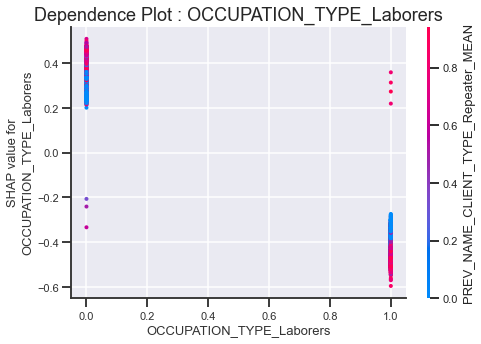

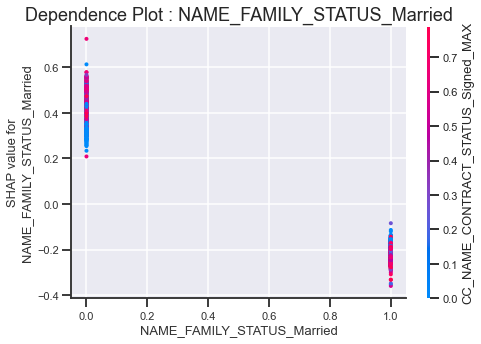

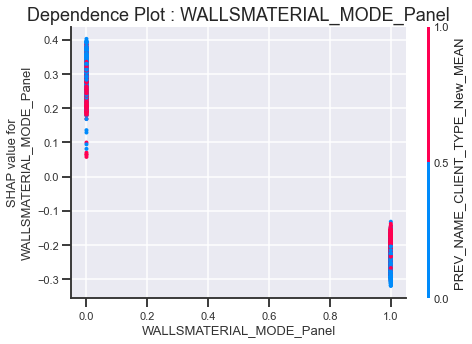

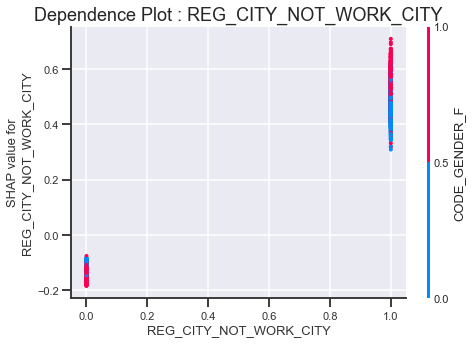

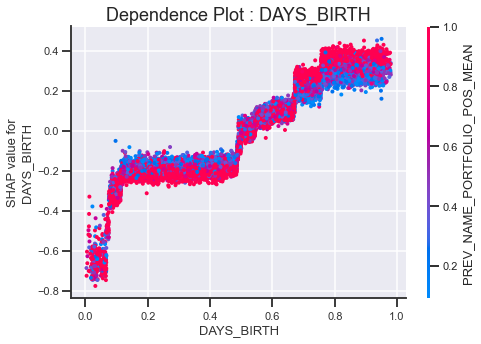

In [23]:
# Diagramme de dépendance
shap.dependence_plot("OCCUPATION_TYPE_Laborers", explainer2.shap_values(X_test), features=X_test, 
                     feature_names=f_names, show=False)
plt.title(f"Dependence Plot : OCCUPATION_TYPE_Laborers")

shap.dependence_plot("NAME_FAMILY_STATUS_Married", explainer2.shap_values(X_test), features=X_test, 
                     feature_names=f_names, show=False)
plt.title(f"Dependence Plot : NAME_FAMILY_STATUS_Married")

shap.dependence_plot("WALLSMATERIAL_MODE_Panel", explainer2.shap_values(X_test), features=X_test, 
                     feature_names=f_names, show=False)
plt.title(f"Dependence Plot : WALLSMATERIAL_MODE_Panel")

shap.dependence_plot("REG_CITY_NOT_WORK_CITY", explainer2.shap_values(X_test), features=X_test, 
                     feature_names=f_names, show=False)
plt.title(f"Dependence Plot : REG_CITY_NOT_WORK_CITY")

shap.dependence_plot("DAYS_BIRTH", explainer2.shap_values(X_test), features=X_test, 
                     feature_names=f_names, show=False)
plt.title(f"Dependence Plot : DAYS_BIRTH")

plt.show()

<div class="alert alert-block alert-info">
    
Le diagramme de dépendance montre la relation entre la valeur réelle et les valeurs SHAP pour une variable particulière du jeu de données.

</div>

In [24]:
# Diagramme de force
#plot the SHAP values for the random sampled observations
idx = np.random.randint(1, len(X_test))
print(f"Force Plot of observation {idx}")
shap.force_plot(np.around(explainer2.expected_value, decimals=4),
                np.around(explainer2.shap_values(X_test.iloc[idx]), decimals=4), 
                X_test.iloc[idx], 
                feature_names=f_names,
                show=False)

Force Plot of observation 10354


In [25]:
# Diagramme de force
#plot the SHAP values for the random sampled observations with predicted probability
print(f"Force Plot of observation {idx}")
shap.force_plot(np.around(explainer2.expected_value, decimals=4),
                np.around(explainer2.shap_values(X_test.iloc[idx]), decimals=4), 
                X_test.iloc[idx], 
                feature_names=f_names,
                link="logit",
                show=False)

Force Plot of observation 10354


In [26]:
# select number of data samples to be explained
select = range(len(X_test))
X_test_sample = shap.sample(X_test, nsamples=10)
# The collective force plot
shap.force_plot(explainer2.expected_value, explainer2.shap_values(X_test_sample), X_test_sample, feature_names= f_names)

<div class="alert alert-block alert-info">
    
Le diagramme de force montre les contributions des valeurs SHAP dans la génération de la prédiction finale. Il montre quelles caractéristiques ont contribué positivement ou négativement, et à quelle hauteur, à la valeur de base pour générer une prédiction.<br>
Ce diagramme peut s'appliquer à un individu ou un ensemble d'individus.

</div>

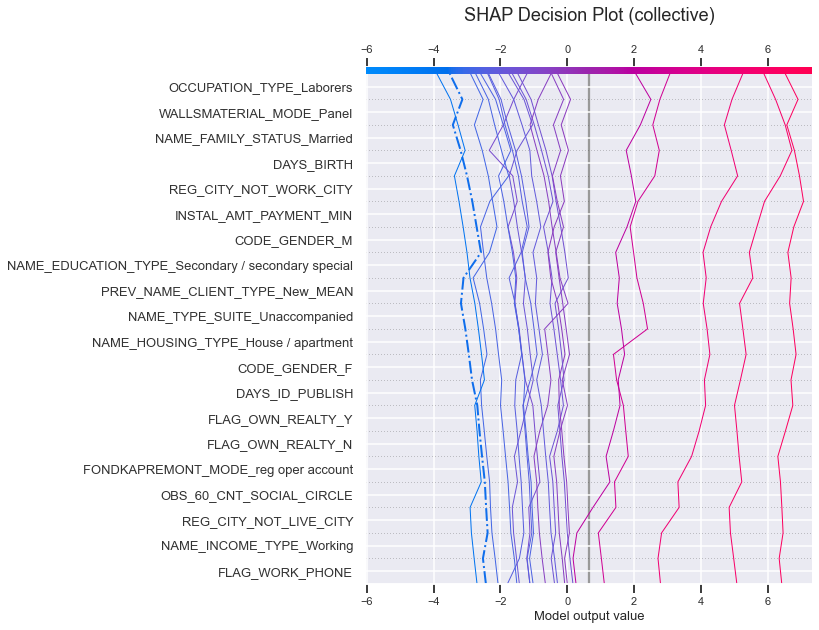

In [27]:
from matplotlib import rcParams

# Tracé de décision
rcParams['axes.titlepad'] = 24
select = range(len(X_test))
X_test_sample = shap.sample(X_test, nsamples=20)
# Plot collective decision plot for 20 data points
plt.title("SHAP Decision Plot (collective)")
shap.decision_plot(explainer2.expected_value, explainer2.shap_values(X_test_sample), X_test_sample, 
                   feature_names=np.array(f_names), highlight=[1], 
                   show= False)
plt.show()

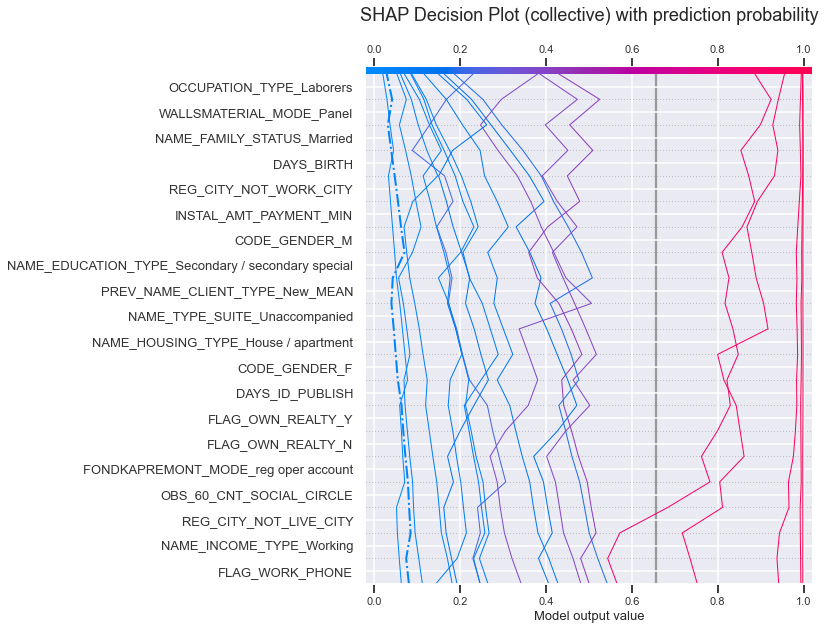

In [28]:
# Tracé de décision
# Plot collective decision plot for 20 data points
plt.title("SHAP Decision Plot (collective) with prediction probability")
shap.decision_plot(explainer2.expected_value, explainer2.shap_values(X_test_sample), X_test_sample, 
                   feature_names=np.array(f_names), highlight=[1], link='logit', show= False)
plt.show()

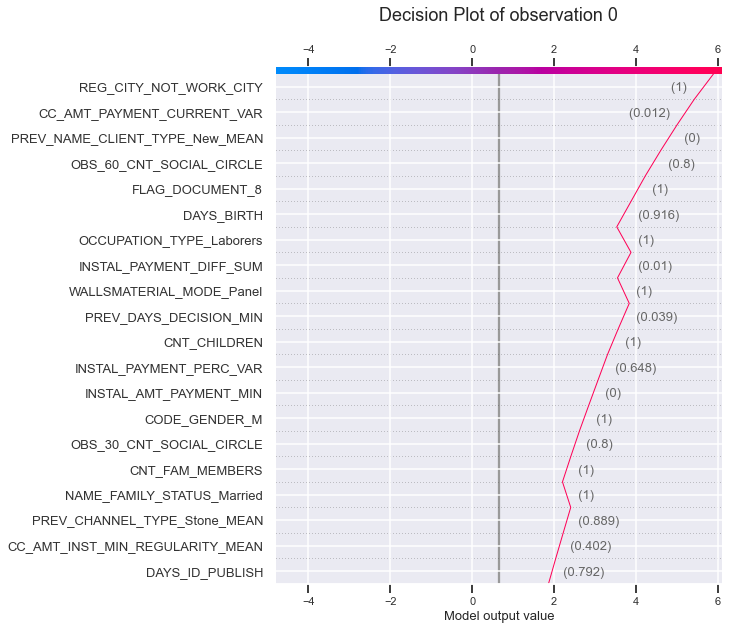

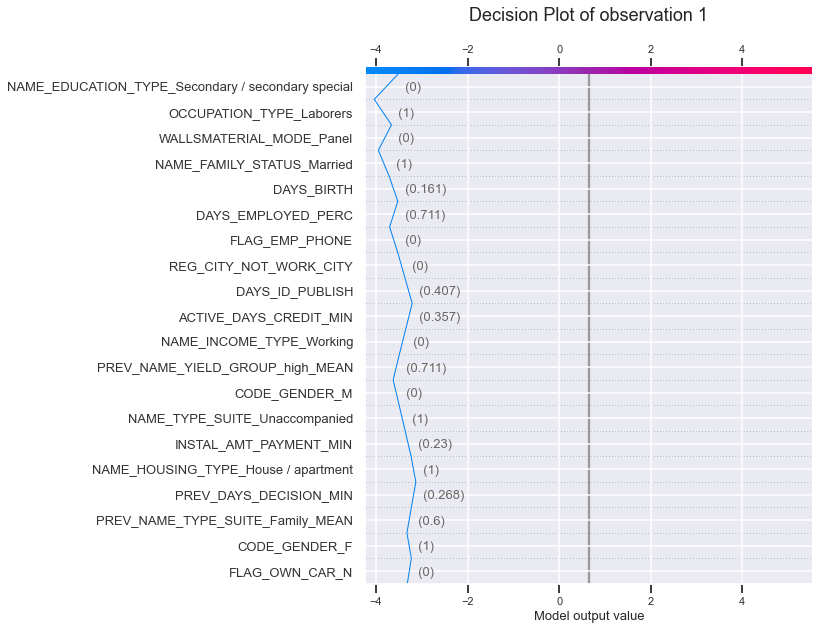

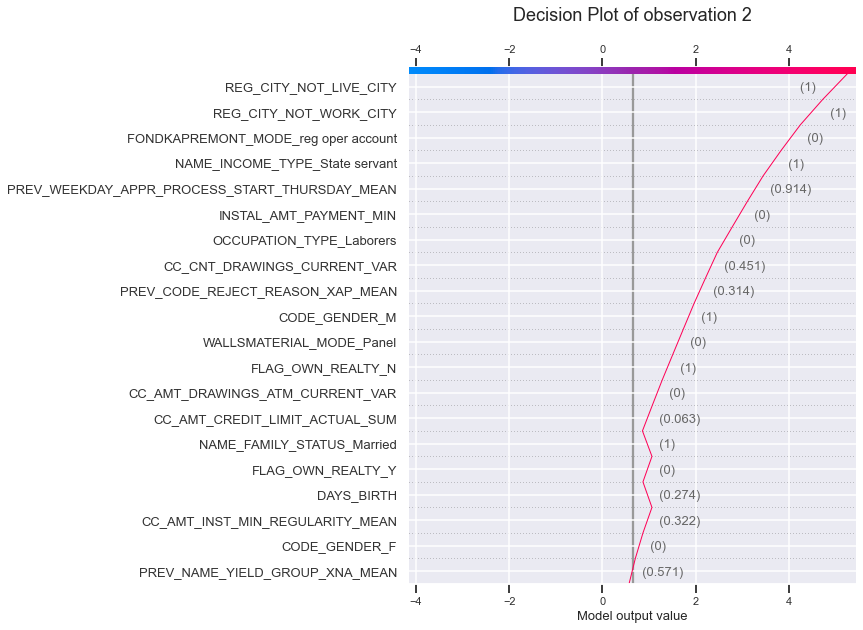

In [29]:
# create decision plot for 3 randomized selected samples
rcParams['axes.titlepad'] = 24
# random sample 3 observations
X_test_sample = shap.sample(X_test, nsamples=3)
for ob in range(len(X_test_sample)):
    #plot the SHAP values for the random sampled observations
    shap.decision_plot(explainer2.expected_value,
                       explainer2.shap_values(X_test_sample.iloc[ob]), 
                       X_test_sample.iloc[ob], 
                       feature_names= np.array(f_names),
                       show=False)
    plt.title(f"Decision Plot of observation {ob}")
    plt.show()

<div class="alert alert-block alert-info">
    
Le diagramme de décision montre le chemin de décision suivi en appliquant les valeurs SHAP des variables, prises une par une, à la valeur attendue afin de générer la valeur prédite sous forme de graphique linéaire.<br>
Ce diagramme peut s'appliquer à un individu ou groupe d'individus, en valeur ou pourcentage.

</div>

In [30]:
# plot waterfall plot
# random sample 3 observations
#X_test_sample = shap.sample(X_test, nsamples=3)
#for ob in range(len(X_test_sample)):
    #plot the SHAP values for the random sampled observations
#    shap.plots.waterfall(explainer2.expected_value,
#                         explainer2.shap_values(X_test_sample.iloc[ob]), 
#                         X_test_sample.iloc[ob],
#                         show=False)
#    plt.title(f"SHAP Waterfall Plot of observation {ob}")
#    plt.show()

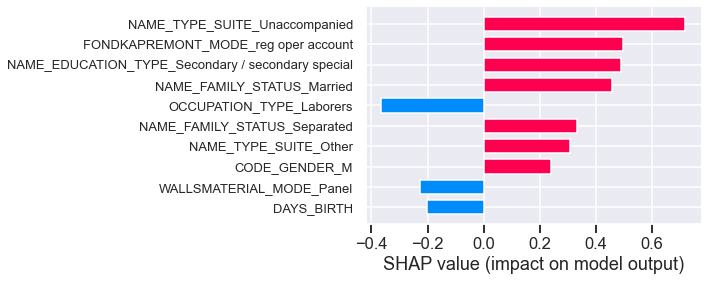

In [31]:
# Tracé à barres
f_count = 10
idx = np.random.randint(1, len(X_test))
shap.bar_plot(explainer2.shap_values(X_test.iloc[idx]), feature_names=f_names, max_display=f_count)

<div class="alert alert-block alert-info">
    
On retrouve ici le diagramme à barres pour un individu, à l'image de LIME ou des features importance des méthodes de classification.

</div>

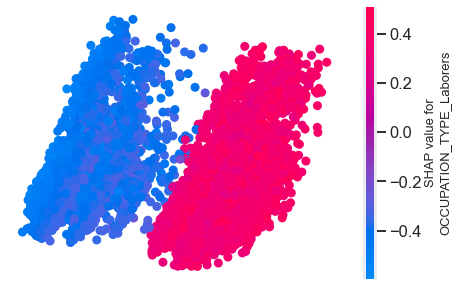

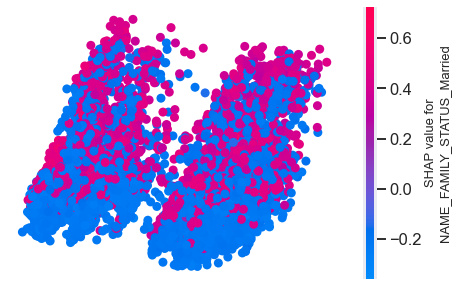

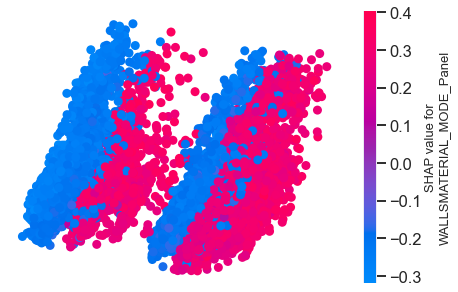

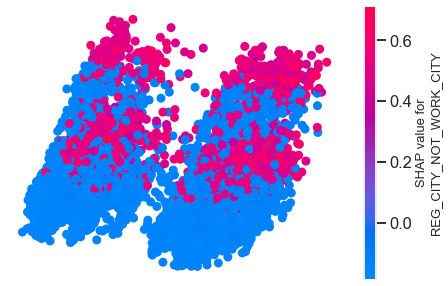

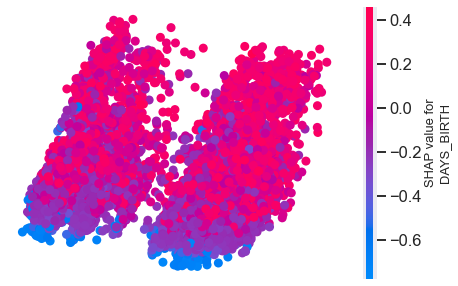

In [32]:
# Tracé d'intégration
shap.embedding_plot("OCCUPATION_TYPE_Laborers", explainer2.shap_values(X_test), feature_names=f_names)
shap.embedding_plot("NAME_FAMILY_STATUS_Married", explainer2.shap_values(X_test), feature_names=f_names) 
shap.embedding_plot("WALLSMATERIAL_MODE_Panel", explainer2.shap_values(X_test), feature_names=f_names) 
shap.embedding_plot("REG_CITY_NOT_WORK_CITY", explainer2.shap_values(X_test), feature_names=f_names)
shap.embedding_plot("DAYS_BIRTH", explainer2.shap_values(X_test), feature_names=f_names)

<div class="alert alert-block alert-info">
    
Le tracé d’intégration projette des valeurs SHAP en deux dimensions d'espace à l’aide de l'analyse en composantes principales pour la visualisation. Cela peut aider à voir la propagation de différentes valeurs shap pour une variable particulière.

</div>

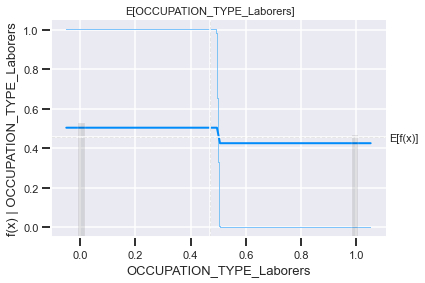

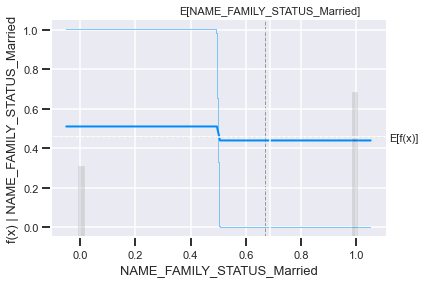

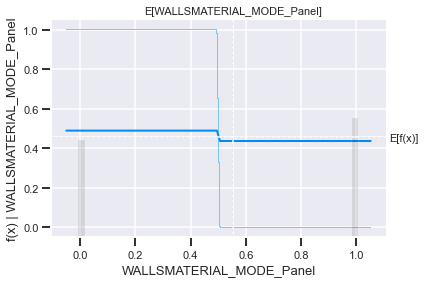

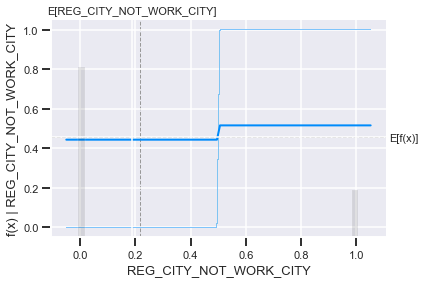

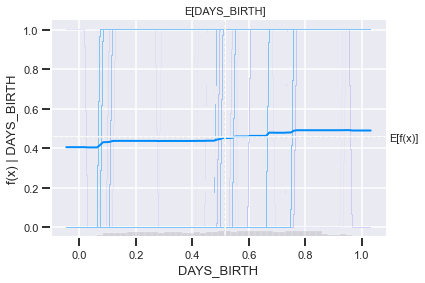

In [33]:
# Diagramme de dépendance partielle
shap.partial_dependence_plot("OCCUPATION_TYPE_Laborers", gb.predict, data=X_test, feature_names=f_names, 
                             model_expected_value=True, feature_expected_value=True, ice=True)
shap.partial_dependence_plot("NAME_FAMILY_STATUS_Married", gb.predict, data=X_test, feature_names=f_names, 
                             model_expected_value=True, feature_expected_value=True, ice=True)
shap.partial_dependence_plot("WALLSMATERIAL_MODE_Panel", gb.predict, data=X_test, feature_names=f_names, 
                             model_expected_value=True, feature_expected_value=True, ice=True)
shap.partial_dependence_plot("REG_CITY_NOT_WORK_CITY", gb.predict, data=X_test, feature_names=f_names, 
                             model_expected_value=True, feature_expected_value=True, ice=True)
shap.partial_dependence_plot("DAYS_BIRTH", gb.predict, data=X_test, feature_names=f_names, 
                             model_expected_value=True, feature_expected_value=True, ice=True)

<div class="alert alert-block alert-info">

## 4. Préparation de l'API et des données de test

</div>

<div class="alert alert-block alert-info">

Création de l'API

</div>

In [34]:
# Enregistrement du modèle
pickle.dump(gb, open('clas_model.pkl', 'wb'))

<div class="alert alert-block alert-info">

Définition du modèle pour les données de test -extraction d'un nombre minimal d'individus pour dépôt sur Heroku

</div>

In [35]:
# Jeux des données du fichier test 
data = pd.read_csv('donnees/transformees/data_test.csv', sep = ',')
print("Données de test transformées : ")
print("   - Nombre d'individus : ", data.shape[0])
print("   - Nombre de variables : ", data.shape[1])
data.head()

Données de test transformées : 
   - Nombre d'individus :  48723
   - Nombre de variables :  442


SK_ID_CURR  DAYS_BIRTH  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0      100001    0.334693         0.887175               1                0   
1      100005    0.400481         0.774489               1                0   
2      100013    0.290146         0.513269               1                0   
3      100028    0.628975         0.415312               1                0   
4      100038    0.681292         0.407809               1                1   

   FLAG_PHONE  FLAG_EMAIL  REG_REGION_NOT_LIVE_REGION  \
0           0           1                           0   
1           0           0                           0   
2           0           0                           0   
3           1           0                           0   
4           0           0                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  ...  \
0                           0                            0  ...   
1                           0                            0  ...   
2                           0                            0  ...   
3                           0                            0  ...   
4                           0                            0  ...   

   FONDKAPREMONT_MODE_org spec account  FONDKAPREMONT_MODE_reg oper account  \
0                                    0                                    1   
1                                    0                                    1   
2                                    0                                    1   
3                                    0                                    1   
4                                    0                                    1   

   FONDKAPREMONT_MODE_reg oper spec account  WALLSMATERIAL_MODE_Block  \
0                                         0                         0   
1                                         0                         0   
2                                         0                         0   
3                                         0                         0   
4                                         0                         0   

   WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
0                         0                              0   
1                         0                              0   
2                         0                              0   
3                         0                              0   
4                         0                              0   

   WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
0                          0                         1   
1                          0                         1   
2                          0                         0   
3                          0                         1   
4                          0                         1   

   WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  
0                                0                          0  
1                                0                          0  
2                                1                          0  
3                                0                          0  
4                                0                          0  

[5 rows x 442 columns]

In [36]:
# Jeux des données d'entraînement du fichier application 
data_i = pd.read_csv('donnees/brutes/application_test.csv', sep = ',')
print("Données de test brutes : ")
print("   - Nombre d'individus : ", data_i.shape[0])
print("   - Nombre de variables : ", data_i.shape[1])
data_i.head()

Données de test brutes : 
   - Nombre d'individus :  48744
   - Nombre de variables :  121


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [37]:
data_sav = data.sample(n = 1000).sort_values(by=['SK_ID_CURR'])
data_sav

SK_ID_CURR  DAYS_BIRTH  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
7          100065    0.878263         0.714464               1   
109        100826    0.609301         0.614145               1   
121        100982    0.923928         0.809226               1   
245        101667    0.945336         0.861748               1   
421        102969    0.779386         0.468668               1   
...           ...         ...              ...             ...   
48203      452133    0.256106         0.416701               1   
48232      452353    0.594153         0.647909               1   
48365      453372    0.142083         0.319855               1   
48626      455228    0.294114         0.514103               0   
48721      456028    0.487564         0.993470               1   

       FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  REG_REGION_NOT_LIVE_REGION  \
7                    1           1           0                           0   
109                  1           0           0                           0   
121                  0           0           0                           0   
245                  0           0           1                           0   
421                  0           0           0                           0   
...                ...         ...         ...                         ...   
48203                0           0           1                           0   
48232                1           1           0                           0   
48365                0           1           0                           0   
48626                0           1           0                           0   
48721                0           0           1                           0   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  ...  \
7                               0                            0  ...   
109                             0                            0  ...   
121                             0                            0  ...   
245                             0                            0  ...   
421                             0                            0  ...   
...                           ...                          ...  ...   
48203                           0                            0  ...   
48232                           0                            0  ...   
48365                           0                            0  ...   
48626                           0                            0  ...   
48721                           0                            0  ...   

       FONDKAPREMONT_MODE_org spec account  \
7                                        0   
109                                      0   
121                                      0   
245                                      0   
421                                      0   
...                                    ...   
48203                                    0   
48232                                    0   
48365                                    0   
48626                                    0   
48721                                    0   

       FONDKAPREMONT_MODE_reg oper account  \
7                                        1   
109                                      1   
121                                      1   
245                                      1   
421                                      1   
...                                    ...   
48203                                    1   
48232                                    0   
48365                                    1   
48626                                    1   
48721                                    1   

       FONDKAPREMONT_MODE_reg oper spec account  WALLSMATERIAL_MODE_Block  \
7                                             0                         0   
109                                           0                         0   
121                                           0                         0   
245       

In [38]:
w_data = data_i.isin(data_sav['SK_ID_CURR'].tolist())
data_i_sav = data_i[w_data['SK_ID_CURR']==True].sort_values(by=['SK_ID_CURR'])
data_i_sav

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
7          100065         Cash loans           M            N               Y   
109        100826         Cash loans           F            N               N   
121        100982         Cash loans           F            N               Y   
245        101667         Cash loans           F            N               N   
421        102969         Cash loans           M            Y               Y   
...           ...                ...         ...          ...             ...   
48204      452133         Cash loans           F            N               Y   
48233      452353         Cash loans           F            N               Y   
48366      453372         Cash loans           F            N               Y   
48627      455228         Cash loans           F            N               N   
48722      456028         Cash loans           M            N               Y   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
7                 0          166500.0    180000.0      14220.0   
109               1          202500.0    450000.0      14517.0   
121               2          112500.0    481176.0      23148.0   
245               0          135000.0    440784.0      27094.5   
421               1          157500.0    509400.0      37197.0   
...             ...               ...         ...          ...   
48204             0          157500.0    904500.0      32616.0   
48233             1           90000.0    225000.0      19440.0   
48366             0          351000.0    521136.0      51673.5   
48627             0          166500.0    511920.0      21519.0   
48722             0          220500.0    166500.0      13284.0   

       AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
7             180000.0  ...                0                0   
109           450000.0  ...                0                0   
121           360000.0  ...                0                0   
245           360000.0  ...                0                0   
421           450000.0  ...                0                0   
...                ...  ...              ...              ...   
48204         904500.0  ...                0                0   
48233         225000.0  ...                0                0   
48366         495000.0  ...                0                0   
48627         405000.0  ...                0                0   
48722         166500.0  ...                0                0   

      FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
7                    0                0                        0.0   
109                  0                0                        0.0   
121                  0                0                        0.0   
245                  0                0                        0.0   
421                  0                0                        0.0   
...                ...              ...                        ...   
48204                0                0                        0.0   
48233                0                0                        NaN   
48366                0                0                        0.0   
48627                0                0                        0.0   
48722                0                0                        0.0   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
7                            0.0                         0.0   
109                          0.0                         0.0   
121                          0.0                         0.0   
245                          0.0                         0.0   
421                          0.0                         0.0   
...                          ...                         ...   
48204                        0.0                         0.0   
48233                        NaN                         NaN   
48366                        0.0           

In [39]:
data_sav.to_csv("donnees/transformees/data_test_for_heroku.csv", sep=',', index=False)
data_sav.head()

SK_ID_CURR  DAYS_BIRTH  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
7        100065    0.878263         0.714464               1                1   
109      100826    0.609301         0.614145               1                1   
121      100982    0.923928         0.809226               1                0   
245      101667    0.945336         0.861748               1                0   
421      102969    0.779386         0.468668               1                0   

     FLAG_PHONE  FLAG_EMAIL  REG_REGION_NOT_LIVE_REGION  \
7             1           0                           0   
109           0           0                           0   
121           0           0                           0   
245           0           1                           0   
421           0           0                           0   

     REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  ...  \
7                             0                            0  ...   
109                           0                            0  ...   
121                           0                            0  ...   
245                           0                            0  ...   
421                           0                            0  ...   

     FONDKAPREMONT_MODE_org spec account  FONDKAPREMONT_MODE_reg oper account  \
7                                      0                                    1   
109                                    0                                    1   
121                                    0                                    1   
245                                    0                                    1   
421                                    0                                    1   

     FONDKAPREMONT_MODE_reg oper spec account  WALLSMATERIAL_MODE_Block  \
7                                           0                         0   
109                                         0                         0   
121                                         0                         0   
245                                         0                         0   
421                                         0                         0   

     WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
7                           0                              0   
109                         0                              0   
121                         0                              0   
245                         0                              0   
421                         0                              0   

     WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
7                            0                         0   
109                          0                         1   
121                          0                         1   
245                          0                         0   
421                          0                         0   

     WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  
7                                  1                          0  
109                                0                          0  
121                                0                          0  
245                                1                          0  
421                                1                          0  

[5 rows x 442 columns]

In [40]:
data_i_sav.to_csv("donnees/transformees/application_test_for_heroku.csv", sep=',', index=False)
data_i_sav.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
7        100065         Cash loans           M            N               Y   
109      100826         Cash loans           F            N               N   
121      100982         Cash loans           F            N               Y   
245      101667         Cash loans           F            N               N   
421      102969         Cash loans           M            Y               Y   

     CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
7               0          166500.0    180000.0      14220.0         180000.0   
109             1          202500.0    450000.0      14517.0         450000.0   
121             2          112500.0    481176.0      23148.0         360000.0   
245             0          135000.0    440784.0      27094.5         360000.0   
421             1          157500.0    509400.0      37197.0         450000.0   

     ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
7    ...                0                0                0                0   
109  ...                0                0                0                0   
121  ...                0                0                0                0   
245  ...                0                0                0                0   
421  ...                0                0                0                0   

    AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
7                          0.0                        0.0   
109                        0.0                        0.0   
121                        0.0                        0.0   
245                        0.0                        0.0   
421                        0.0                        0.0   

     AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
7                           0.0                        0.0   
109                         0.0                        0.0   
121                         0.0                        0.0   
245                         0.0                        0.0   
421                         0.0                        0.0   

     AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
7                          0.0                         2.0  
109                        1.0                         0.0  
121                        1.0                         0.0  
245                        1.0                         3.0  
421                        1.0                         3.0  

[5 rows x 121 columns]